<h2 style="text-align:center;color:#004d80"> Test AInwater</h2>
<h3 style="text-align:center;color:#FFFFF">by: Constanza Córdova </h3>

**Descripción:** En la siguiente tabla tenemos la información de una semana en una planta de tratamiento. En la base tenemos las siguientes variables
- `date`: fecha de la lectura
- `time`: hora de la lectura
- `do_level`: nivel de oxígeno
- `h2o_level`: nivel de agua
- `blower_hz`: hz de giro del motor
- `cycle_id`: label para identificar los ciclos de funcionamiento

caracterizar el funcionamiento de la planta durante esta semana.

- hz totales por ciclo
- crear un label que identifique cual es en que posición del día se encuentra cada ciclo
- comparar el gasto energético entre los diferentes ciclos de cada día
- nivel medio de oxígeno por ciclo (y su distribución)
- nivel medio de oxígeno por ciclo para blower_hz > 0 (y su distribución)

**bonus:**
- caracterizar el nivel de agua por ciclo
- desarrollar un modelo de clusterización de los ciclos de esta semana

### Análisis Exploratorio
Es importante señalar que antes de responder a las preguntas planteadas se realizará un breve analisis exploratorio para comprender los datos e identificar si se requiere hacer modificaciones al data set 

#### Importacón de Librerías

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import pickle

import warnings
warnings.simplefilter("ignore")

import funciones_test as ft

#### Importación del data frame 

In [42]:
df = pd.read_csv('base_test_planta_tupiniquim.csv', parse_dates={'date_time': ['date', 'time']}).drop('Unnamed: 0', axis =1)
df['date'] = df['date_time'].dt.date
df['time'] = df['date_time'].dt.time

Insepección del set de datos 

In [43]:
df.sample(5, random_state= 123)

,date_time,do_level,h2o_level,blower_hz,cycle_id,date,time
1004,2021-04-16 02:05:56,1.92238,3.959820,34.270000,11,2021-04-16,02:05:56
2776,2021-04-19 18:33:40,3.69625,5.118412,26.440001,29,2021-04-19,18:33:40
1987,2021-04-18 03:09:18,2.65040,4.192580,26.440001,21,2021-04-18,03:09:18
2404,2021-04-19 00:00:03,5.51139,4.970936,0.000000,25,2021-04-19,00:00:03
2940,2021-04-20 02:42:43,1.52203,4.003727,0.000000,31,2021-04-20,02:42:43


In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3366 entries, 0 to 3365
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date_time  3366 non-null   datetime64[ns]
 1   do_level   3366 non-null   float64       
 2   h2o_level  3366 non-null   float64       
 3   blower_hz  3366 non-null   float64       
 4   cycle_id   3366 non-null   int64         
 5   date       3366 non-null   object        
 6   time       3366 non-null   object        
dtypes: datetime64[ns](1), float64(3), int64(1), object(2)
memory usage: 184.2+ KB


Se inspecciona el tipo de datos del Dataframe y se observa que no hay valores nulos, por lo tanto se considera que el archivo cuenta con todas las observaciones.

#### Tabla 1 - Estadisticos básicos de la variación de las observaciones

In [45]:
df_delta = df.iloc[:, :-1] - df.iloc[:, :-1].shift(1)
df_delta['date_time'].describe()

count                      3365
mean     0 days 00:02:59.686181
std      0 days 00:00:06.939919
min             0 days 00:00:01
25%             0 days 00:03:00
50%             0 days 00:03:00
75%             0 days 00:03:00
max             0 days 00:03:01
Name: date_time, dtype: object

Se observa que las mediciones fueron tomadas cada 3 minutos aproximadamente de forma constante

#### Tabla 2 - Estadisticos de las variables de operación durante los 7 días

In [46]:
df.iloc[:, :-3].describe()

,do_level,h2o_level,blower_hz
count,3366.000000,3366.000000,3366.000000
mean,1.360852,4.586752,12.140579
std,1.582510,0.443547,19.798966
min,0.004908,3.910520,0.000000
25%,0.057467,4.253216,0.000000
50%,0.603368,4.397857,0.000000
75%,2.339908,5.018035,26.440001
max,5.716060,5.412021,50.240002


#### Histograma de variables 

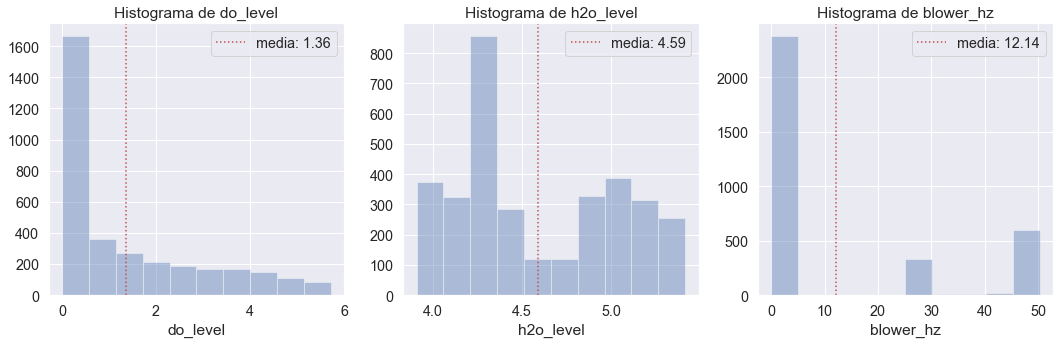

In [47]:
plt.figure(figsize = (18,5))
plt.subplot(1, 3, 1)
ft.histograma_data(df, 'do_level')
plt.subplot(1, 3, 2)
ft.histograma_data(df, 'h2o_level')
plt.subplot(1, 3, 3)
ft.histograma_data(df, 'blower_hz')

De acuerdo a los estadisticos generales del data set se observa que los niveles de oxigeno en el agua se encuentran más concentrado en valores cercanos a cero, la media global es de 1.36 de nivel de oxigeno.

Respecto al nivel de agua se observan dos modas y varía su nivel en dos extremos que van entre 3.9 a 5.4. Esto se puede explicar dado que el proceso es ciclico puede ocurrir carga y descarga de agua entre esos niveles

Respecto a el uso del soplador se distinguen 3 modas, una que responde a cuando el soplador no está operativo por lo que el consumo es cero, otra donde el consumo es medio cercano a 30 y por último en su máximo consumo que es 50

#### Boxplot de variables por ciclo

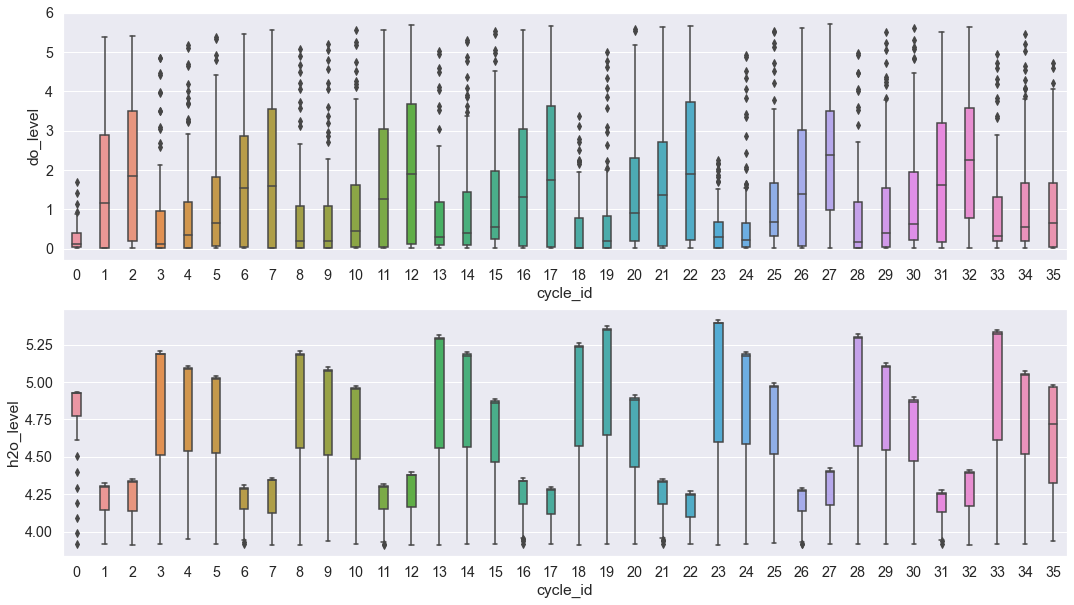

In [48]:
plt.figure(figsize = (18,10))
plt.subplot(2, 1, 1)
ft.boxplot_group(df, 'do_level')
plt.subplot(2, 1, 2)
ft.boxplot_group(df, 'h2o_level')

De acuerdo a los gráficos boxplot se observa que los ciclos tienen una distribución distinta entre ellos en el nivel de oxigeno y agua. Sin embargo, se observa que existen ciclos que tienen similitud en su distribución y la variación de los niveles de oxigeo y agua son ciclicas.  

### Caracterización del funcionamiento de la planta

In [49]:
ft.historico_variables(df)

Luego de graficar los datos históricos de las tres variables se observa a alto nivel que un día de operación de la planta está compuesto por 5 ciclos, los primeros dos ciclos comienzan con un mayor nivel de oxigeno, menor nivel de agua y la duración en que el soplador funciona a 50 hz es menor que en los tres ciclos restantes. Se observa además que a partir del tercer ciclo del día hay un aumento del nivel de agua y el nivel de oxigeno cae en relación a los ciclos anteriores, en estos casos se observa que la duración de operación del soplador a 50 hz es mayor

#### Generación de arreglo para análisis

A continuación se presenta script para relalizar arreglo del data set y observar de forma resumida las variables. 
Los pasos de transformación fueron los siguientes:

- 1. Total de Hz del soplador por ciclo: suma de las observaciones para la variable Hz agrupada por ciclo
- 2. Niveles de DO y H2O promedio por ciclo: Media aritmetica de las observaciones de DO y H2O por ciclo
- 3. Niveles de DO cuando está el soplador encendido: Media aritmetica de las observaciones de DO cuando blower_hz > 0
- 4. Datos sobre temporalidad de los ciclos: Se determina la duración de cada ciclo
- 5. Momento del día del ciclo: Se realiza un arreglo de acuerdo a la hora de inicio y termino del ciclo. Se establecen 5 momentos del dia de ciclos: 
    - Turno Mañana que comprende desde las 6 hrs hasta las 12 hrs 
    - Turno Media-Mañana que comprende un ciclo iniciado durante el Turno Mañana pero que finalizó pasado las 12 hrs 
    - Turno Tarde que comprende desde las 12 hrs hasta las 19 hrs 
    - Turno Noche que comprende desde las 19 hrs hasta las 24 hrs 
    - Turno Madrugada que comprende desde las 24 hrs hasta las 6 hrs 
    
 Adicionalmente se omite el ciclo 0 dado que las mediciones registradas corresponden a 1 hora 41 minutos del ciclo versus el tiempo de los ciclos siguientes. Dada esta información se puede deducir que los registros del ciclo 0 se encuentran incompletos, además se observa que el ciclo 0 no tiene operación del soplador por lo que no nos entregará información relevante para el análisis

In [50]:
# 1. Total de Hz del soplador por ciclo
# resumen de hz por ciclo se considerará la suma de todas las frecuencias registradas para cada ciclo
d_hz = df.loc[:, ['cycle_id', 'blower_hz']].groupby(['cycle_id']).sum()
d_hz.rename(columns= {'blower_hz': 'total_hz'}, inplace = True)

# 2. Niveles de DO y H2O promedio por ciclo
# resumen DO y H2O Level se considerará como la media de las observaciones resgitradas para cada ciclo
d_do_h2o = df.loc[:, ['cycle_id', 'do_level', 'h2o_level']].groupby(['cycle_id']).mean()
d_do_h2o.rename(columns= {'do_level': 'do_mean', 'h2o_level': 'h2o_mean'}, inplace = True)

# 3. Niveles de DO cuando está el soplador encendido:
d_do_blower = df[df['blower_hz']>0].loc[:, ['cycle_id', 'do_level']].groupby(['cycle_id']).mean()
d_do_blower.rename(columns= {'do_level': 'do_mean_blwon'}, inplace = True)


# 4. Datos sobre temporalidad de los ciclos
d_min_time = df.loc[:, ['cycle_id', 'date_time']].groupby(['cycle_id']).min()
d_min_time.rename(columns= {'date_time': 'inicio_ciclo'}, inplace = True)
d_max_time = df.loc[:, ['cycle_id', 'date_time']].groupby(['cycle_id']).max()
d_max_time.rename(columns= {'date_time': 'fin_ciclo'}, inplace = True)

    # Se Concatenan los arreglos realizados previamente 
df_resume_cycle = pd.concat([d_hz, d_do_blower, d_do_h2o, d_min_time, d_max_time], axis = 1)
df_resume_cycle.index = df_resume_cycle.index.map('Ciclo {}'.format)

    # duración del ciclo
df_resume_cycle['duracion'] = df_resume_cycle['fin_ciclo'] - df_resume_cycle['inicio_ciclo']

# 5. Momento del día del ciclo
# Arreglo para identificar momento del dia que inicia el ciclo
turno = {}

for i, hora_inicio in enumerate(df_resume_cycle['inicio_ciclo'].dt.hour):
    key = df_resume_cycle.index[i]
    hora_termino = df_resume_cycle['fin_ciclo'].dt.hour.iloc[i]
    
    if hora_inicio >=6 and hora_inicio < 12 and hora_termino > 12:
        turno[key] = 'Media-Mañana'
    
    elif hora_inicio >= 6 and hora_inicio < 12:
        turno[key] = 'Mañana'
    
    elif hora_inicio >= 12 and hora_inicio < 19:
        turno[key] = 'Tarde'
        
    elif hora_inicio >= 19 and hora_inicio < 24:
        turno[key] = 'Noche'
        
    else:
        turno[key] = 'Madrugada'

d_turno = pd.DataFrame([[key, turno[key]] for key in turno.keys()], columns=['cycle_id', 'time_of_day'])
d_turno.set_index('cycle_id', inplace = True)

# Se concatena el arreglo de turno al dataframe de resumen de ciclos
df_resume_cycle = pd.concat([df_resume_cycle, d_turno], axis = 1)

df_resume_cycle = df_resume_cycle.iloc[1:]
df_resume_cycle = df_resume_cycle.rename_axis('ciclo').reset_index()
df_resume_cycle.head()

,ciclo,total_hz,do_mean_blwon,do_mean,h2o_mean,inicio_ciclo,fin_ciclo,duracion,time_of_day
0,Ciclo 1,995.250010,2.407957,1.625739,4.221912,2021-04-14 01:44:36,2021-04-14 06:32:38,04:48:02,Madrugada
1,Ciclo 2,862.550003,3.023039,1.992185,4.236787,2021-04-14 06:35:38,2021-04-14 11:20:40,04:45:02,Mañana
2,Ciclo 3,1486.809999,1.130939,0.776205,4.859091,2021-04-14 11:23:40,2021-04-14 16:11:42,04:48:02,Media-Mañana
3,Ciclo 4,1334.240005,1.126024,0.981913,4.811575,2021-04-14 16:14:42,2021-04-14 20:59:44,04:45:02,Tarde
4,Ciclo 5,1263.920008,1.527396,1.240273,4.768018,2021-04-14 21:02:44,2021-04-15 01:47:46,04:45:02,Noche


El nuevo dataframe tiene la siguiente estructura:
- `ciclo` : Id del ciclo
- `total_hz`: Total de Hz por ciclo 
- `do_mean_blwon`: Media de oxigeno cuando el soplador está en operación durante el ciclo
- `do_mean`: Media de oxigeno durante el ciclo
- `h2o_mean`: Media de nivel de agua del ciclo
- `inicio_ciclo`: Fecha y hora en que inició el ciclo
- `fin_ciclo`: Fecha y hora en que terminó el ciclo
- `duracion`: Tiempo de duración del ciclo
- `time_of_day`: Momento del día en que transcurre el ciclo


In [51]:
# Script para diferenciar por color los turnos para los gráficos de barra que se realizarán a continuación
colors = ['',]*len(df_resume_cycle)

for i, t in enumerate(df_resume_cycle['time_of_day']):
    
    if t == 'Mañana':
        colors[i] = 'LightBlue'
        
    elif t == 'Media-Mañana':
        colors[i] = 'skyblue'
    
    elif t == 'Tarde':
        colors[i] = 'slateblue'
        
    elif t == 'Noche':
        colors[i] = 'darkslateblue'
        
    elif t == 'Madrugada':
        colors[i] = 'lightskyblue'

#### Hz totales del soplador por ciclo 

In [52]:
fig_blower_cycle = go.Figure()       
fig_blower_cycle.add_trace(go.Bar(x=[df_resume_cycle['inicio_ciclo'].dt.date,df_resume_cycle['ciclo']], y=df_resume_cycle['total_hz'], marker_color= colors))
fig_blower_cycle.update_layout( title_text='Hz totales por ciclo')

In [53]:
fig_h2o_cycle = go.Figure()     
fig_h2o_cycle.add_trace(go.Bar(x=[df_resume_cycle['inicio_ciclo'].dt.date,df_resume_cycle['ciclo']], y=df_resume_cycle['h2o_mean'], marker_color= colors))
fig_h2o_cycle.update_layout( title_text='Nivel medio de agua por ciclo')
fig_h2o_cycle.update_layout(yaxis= dict(range=[4, 5.2]))

In [54]:
fig_do_cycle = go.Figure()     
fig_do_cycle.add_trace(go.Bar(x=[df_resume_cycle['inicio_ciclo'].dt.date,df_resume_cycle['ciclo']], y=df_resume_cycle['do_mean'], marker_color= colors))
fig_do_cycle.update_layout( title_text='Nivel medio de oxigeno por ciclo')

De acuerdo al gráfico de Hz totales por ciclo se observa que existen ciclos bien definidos durante el día y responden a los turnos del día. Se obverva que los ciclos 3, 8, 13, 18, 23, 28 y 33 son los ciclos en donde más se hace uso del soplador durante cada día, estos ciclos coindicen en que son los que comenzaron en el turno identificado como media mañana, lo cual puede tener relación con el aumento del nivel de agua para ese turno, se puede suponer que durante ese horario existe mayor uso de agua por parte de la población y por ende existe mayor volumen de agua a tratar y el nivel de oxigeno también es menor. Tambien se observa que los ciclos que corresponde a turno de madrugada y tarde son los que tiene mayor nivel de oxigeno, menor nivel de agua y se hace menor uso de los sopladores 

#### Generación de arreglo para comparar consumo por dia y tramo horario

Se realizó un arreglo para poder transformar a matriz los valores de Hz de cada ciclo para poder comparar mediante mapa de calor el gasto energético de los ciclos de acuerdo a la fecha y horario del ciclo 

In [55]:
# Nuevo df con columnas que se usarán en el análisis
df_heatmap = df_resume_cycle.loc[ :, ['inicio_ciclo', 'time_of_day','total_hz']]


# Se generará un arreglo que permita agrupar en listas los valores Hz del soplador de los ciclos de 1 día 
previous_date = df_heatmap['inicio_ciclo'].dt.date.iloc[0]
global_list = []
pre_list = []
day_week = []

for row, value in enumerate(df_heatmap['total_hz']):
   
    now_date = df_heatmap['inicio_ciclo'].dt.date.iloc[row]
    
    if now_date!= previous_date:           
        day_week.append(str(previous_date))
        previous_date = df_heatmap['inicio_ciclo'].dt.date.iloc[row]
        global_list.append(pre_list)
        pre_list = []
        
    pre_list.append(value)
    if previous_date is not None:
        day_week.append(str(previous_date))
        global_list.append(pre_list)

# Se realiza un diccionario con llave: día de la semana y valor: hz del soplador    
dict_data = dict(zip(day_week, global_list))
dict_data

# Se crea dataframe a partir del diccionario obtendo con indice de los turnos de cada ciclo
df_heatmap_matrix = pd.DataFrame(dict_data, index = df_heatmap['time_of_day'].unique())

df_heatmap_matrix

,2021-04-14,2021-04-15,2021-04-16,2021-04-17,2021-04-18,2021-04-19,2021-04-20
Madrugada,995.250010,925.799997,868.780008,930.579992,860.780001,874.450003,814.410011
Mañana,862.550003,907.110008,849.270002,843.070013,788.710007,864.540005,921.340002
Media-Mañana,1486.809999,1432.870005,1415.350006,1483.140001,1542.450014,1391.880007,1431.070002
Tarde,1334.240005,1381.800003,1339.870001,1411.260006,1379.100006,1330.100002,1316.410004
Noche,1263.920008,1336.389988,1261.180002,1243.099998,1259.520004,1289.200003,1228.889996


#### Comparación gasto energético por ciclos

In [56]:
fig_heatmap = px.imshow( df_heatmap_matrix, labels=dict(x="Fecha", y="Momento del dia", color="Hz Soplador"),)
fig_heatmap.update_layout( title_text='Mapa de calor consumo energético por dia y momento del día')
fig_heatmap.show()  

In [57]:
fig_scatter = px.scatter(df_heatmap, x = df_heatmap['inicio_ciclo'].dt.date, y = 'total_hz', color= 'time_of_day')
fig_scatter.update_layout( title_text='Hz totales por día y momento del día')
fig_scatter.show()

A partir del mapa de calor y considerando que la relación entre Hz es directamente proporcional al gasto energético se observan diferencias en el gasto energético en dos niveles. Se podría decir que hay una banda de bajo consumo que corresponde a los ciclos de la madrugada y mañana, y una banda de alto consumo que corresponde a los ciclos de media mañana, tarde y noche. Se oserva, al igual que en el análisis anterior, que el horario de mayor consumo energético es la de media mañana, siendo el día 18 de abril el que tuvo mayor consumo en ese horario 

#### Nivel medio de oxígeno por ciclo

In [58]:
fig_mean_do = go.Figure()
fig_mean_do.add_trace(go.Bar(name='Media general', x= df_resume_cycle['ciclo'], y=df_resume_cycle['do_mean']))
fig_mean_do.add_trace(go.Bar(name='Media con blower_hz >0', x=df_resume_cycle['ciclo'], y=df_resume_cycle['do_mean_blwon']))
fig_mean_do.update_layout(title_text='Media de Nivel de oxigeno por ciclo')
fig_mean_do.update_layout(xaxis = dict( autorange = False, range =[-0.5, 4.5], 
                                       rangeslider = dict(autorange= False, range = [-0.5, 34.5])))
fig_mean_do.show()

#### Distribución del nivel de oxigeno por ciclo de operación 

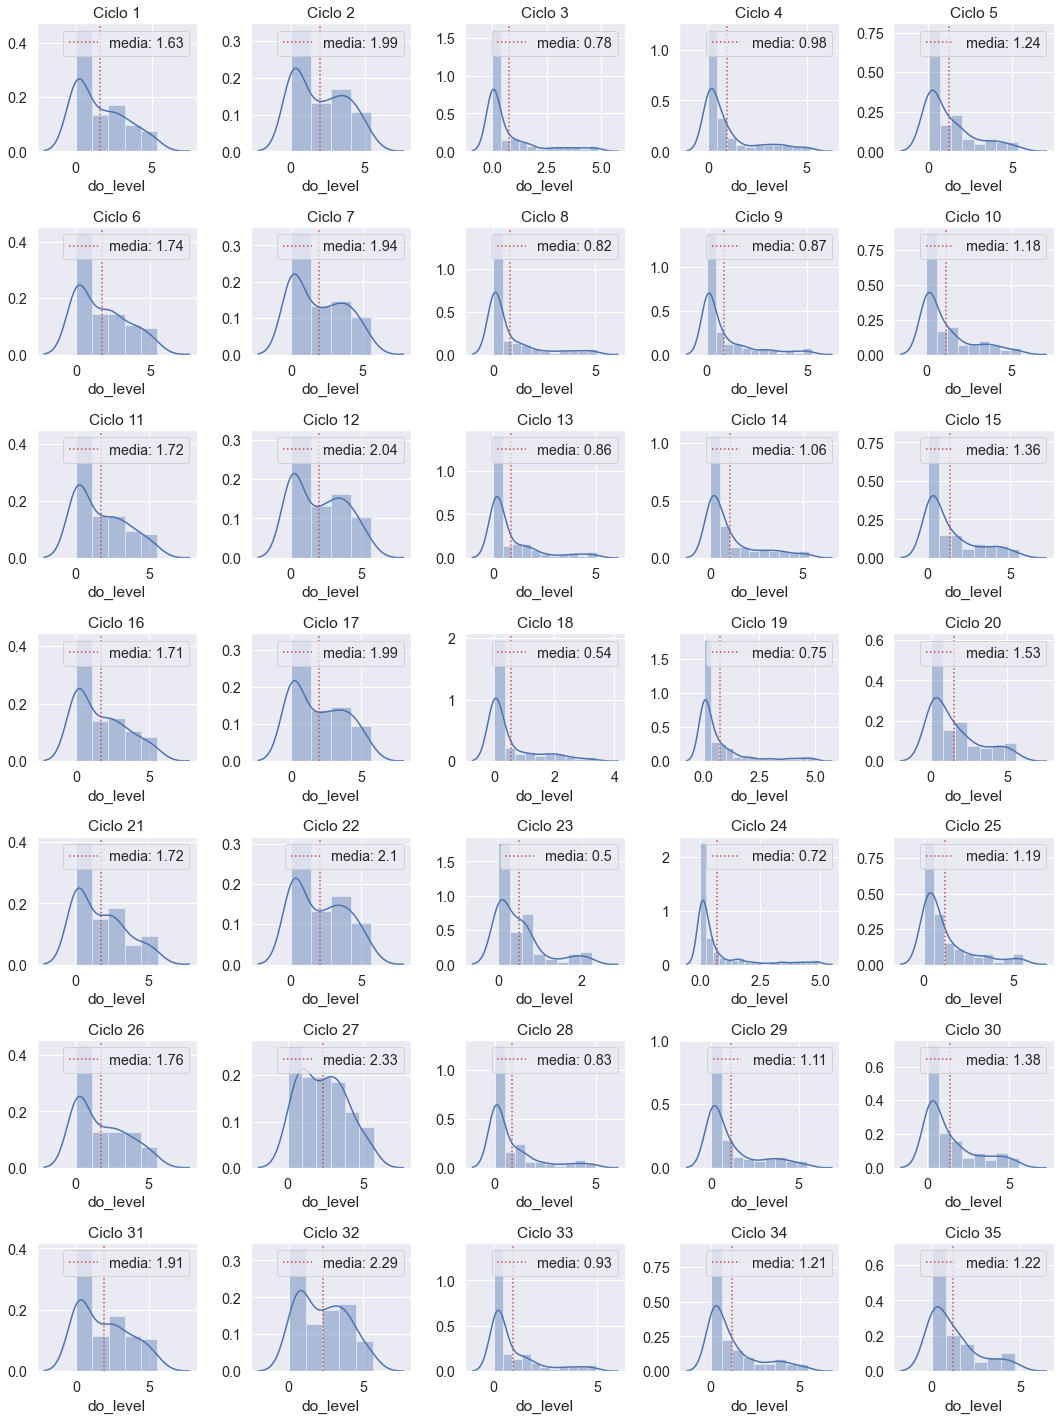

In [59]:
id_ciclos = df[df['cycle_id']!= 0]['cycle_id'].unique()

fig = plt.figure(figsize = (15,20))
for ciclo in id_ciclos:
    plt.subplot(7, 5, ciclo)
    ft.distribucion_clase(df, 'do_level', 'cycle_id', ciclo, f'Ciclo {ciclo}')
fig.tight_layout()

#### Distribución del nivel de oxigeno por ciclo de operación cuando el soplador está en funcionamiento

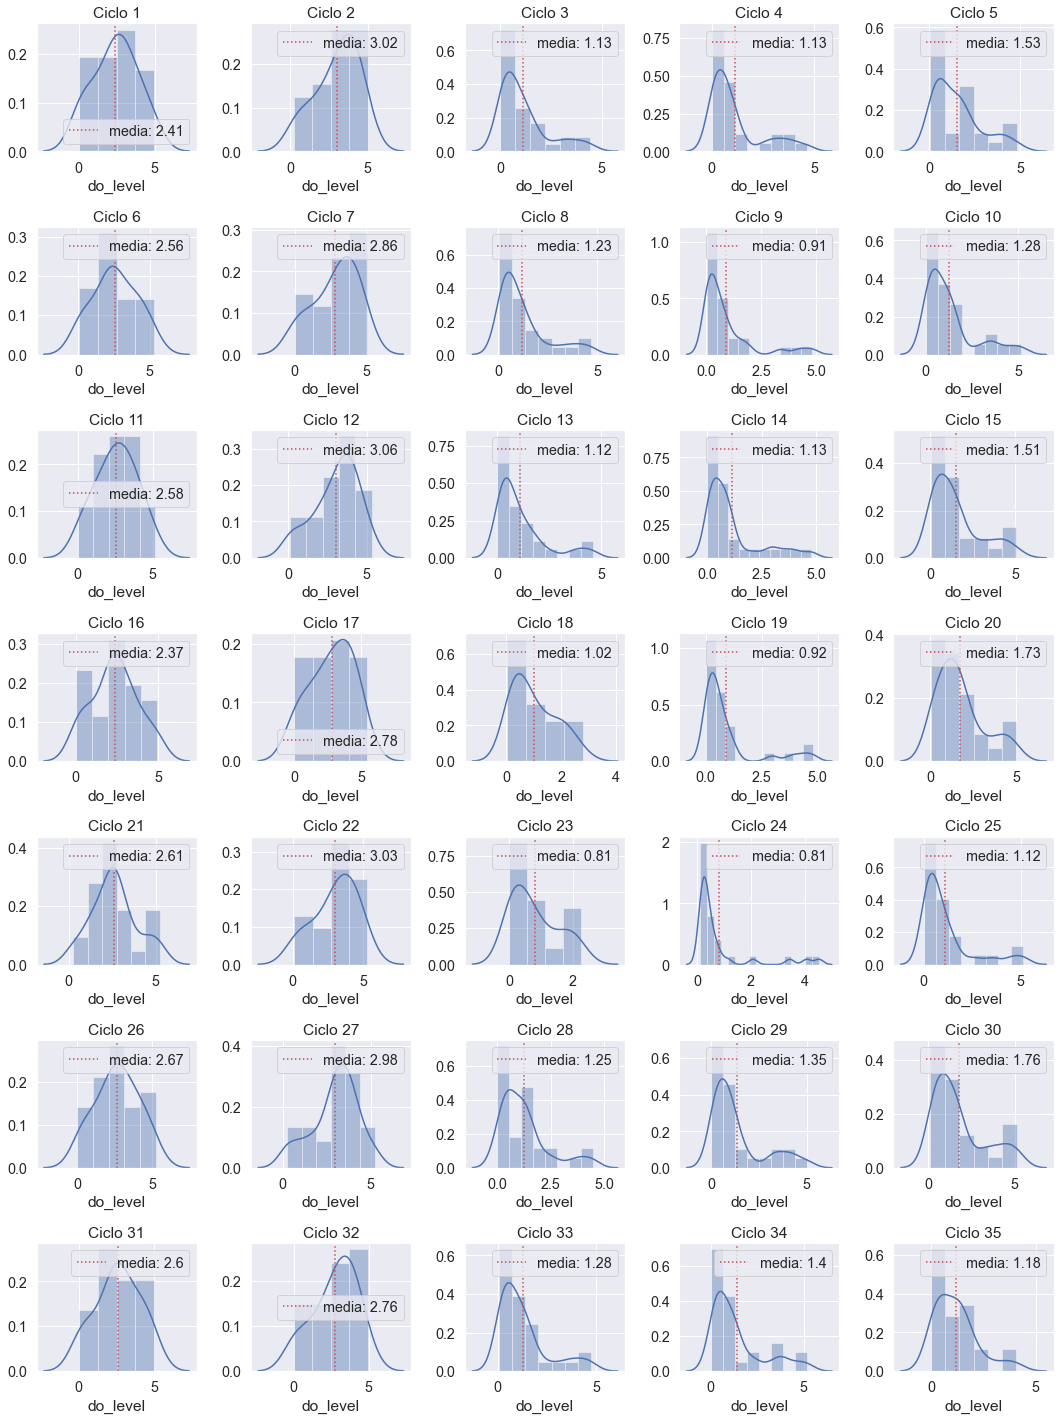

In [60]:
df_blower_on = df[df['blower_hz']>0]

fig = plt.figure(figsize = (15,20))
for ciclo in id_ciclos:
    plt.subplot(7, 5, ciclo)
    ft.distribucion_clase(df_blower_on, 'do_level', 'cycle_id', ciclo, f'Ciclo {ciclo}')
fig.tight_layout()

### Clusterización de los ciclos

Para el estudio de clusterización de los ciclos se utilizará el dataframe preprocesado (df_resume_cycle) que resume las variables de cada ciclo. En este caso se utilizará para la construcción de la matriz la siguientes variables:
- total_hz
- do_mean_blwon
- do_mean
- h2o_mean

Dado que las unidades de medida de las variables son distintas se estándarizarán  los valores aplicando StandarScaler

#### Preparación de matriz 

In [61]:
X_matrix = StandardScaler().fit_transform(df_resume_cycle.iloc[:, 1:5])

#### Estudio de número de cluster - Elbow graph
Se realizará un estudio de nùmero de cluster mediante el metodo de elbow graph donde se evaluará la invercia evaluando desde 1 a 7 cluster 


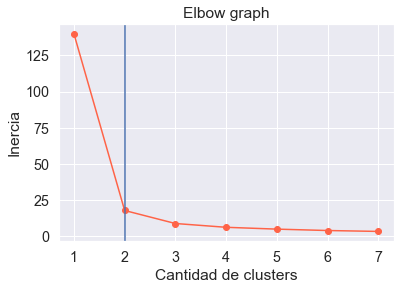

In [62]:
# generamos array para guardar los resultados de la inercia.
inertia = []
# Se evaluará con 7 cluster
for i in range(1, 8):
# Agregamos la inercia
    inertia.append(KMeans(n_clusters=i).fit(X_matrix).inertia_)
# graficamos el resultado
plt.plot(range(1, 8), inertia, 'o-', color='tomato')
plt.xlabel("Cantidad de clusters")
plt.ylabel("Inercia")
plt.title("Elbow graph")
plt.axvline(2)

De acuerdo al gráfico se observa que los ciclos se pueden categorizar en dos cluster por lo que realizaremos el modelo con un nùmero de cluster igual a 2

In [63]:
kmeans_model = KMeans(n_clusters=2).fit(X_matrix)
C = kmeans_model.cluster_centers_
color_label = ['blue', 'red']
cluster_label = ['cluster 1', 'cluster 2']
asigna_color = []
cluster_ciclo = []


for i in kmeans_model.labels_:
    asigna_color.append(color_label[i])
    cluster_ciclo.append(cluster_label[i])

df_resume_cycle['cluster'] = pd.Series(cluster_ciclo, dtype="str")
df_resume_cycle.head(10)

,ciclo,total_hz,do_mean_blwon,do_mean,h2o_mean,inicio_ciclo,fin_ciclo,duracion,time_of_day,cluster
0,Ciclo 1,995.250010,2.407957,1.625739,4.221912,2021-04-14 01:44:36,2021-04-14 06:32:38,04:48:02,Madrugada,cluster 2
1,Ciclo 2,862.550003,3.023039,1.992185,4.236787,2021-04-14 06:35:38,2021-04-14 11:20:40,04:45:02,Mañana,cluster 2
2,Ciclo 3,1486.809999,1.130939,0.776205,4.859091,2021-04-14 11:23:40,2021-04-14 16:11:42,04:48:02,Media-Mañana,cluster 1
3,Ciclo 4,1334.240005,1.126024,0.981913,4.811575,2021-04-14 16:14:42,2021-04-14 20:59:44,04:45:02,Tarde,cluster 1
4,Ciclo 5,1263.920008,1.527396,1.240273,4.768018,2021-04-14 21:02:44,2021-04-15 01:47:46,04:45:02,Noche,cluster 1
5,Ciclo 6,925.799997,2.561532,1.744641,4.211333,2021-04-15 01:50:46,2021-04-15 06:35:48,04:45:02,Madrugada,cluster 2
6,Ciclo 7,907.110008,2.859511,1.941446,4.241424,2021-04-15 06:38:48,2021-04-15 11:26:50,04:48:02,Mañana,cluster 2
7,Ciclo 8,1432.870005,1.231385,0.821631,4.868612,2021-04-15 11:29:50,2021-04-15 16:14:52,04:45:02,Media-Mañana,cluster 1
8,Ciclo 9,1381.800003,0.913515,0.868065,4.789042,2021-04-15 16:17:52,2021-04-15 21:02:54,04:45:02,Tarde,cluster 1
9,Ciclo 10,1336.389988,1.281851,1.184406,4.716633,2021-04-15 21:05:54,2021-04-16 01:50:56,04:45:02,Noche,cluster 1


De acuerdo a la clusterización mediante KMeans con nro cluster = 2, hay 21 ciclos que quedaron agrupados en el cluster 1 y 14 ciclos que quedaron agrupados en el cluster 2. Los ciclos que corresponden al cluster 1 fueron aquellos que se etiquetaron como horario Media-mañana, tarde y noche y que coinciden con ser los momentos del día con mayor consumo energético. En cambio los ciclos que corresponden al claster 2 son aquellos que se podrían clasificar como bajo consumo energético

**Gráfico 2D - total_hz vs do_mean_blwon**

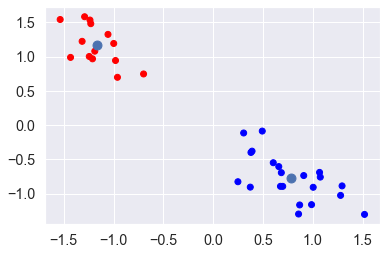

In [64]:
var1 = 0
var2 = 1

plt.scatter(X_matrix[:,var1], X_matrix[:,var2], c=asigna_color)
plt.scatter(C[:,var1], C[:,var2], marker='o', s=80)

**Gráfico 2D - total_hz vs h2o_mean**

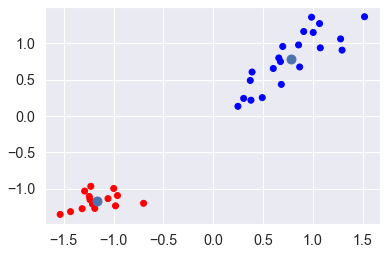

In [65]:
var1 = 0
var2 = 3

plt.scatter(X_matrix[:,var1], X_matrix[:,var2], c=asigna_color)
plt.scatter(C[:,var1], C[:,var2], marker='o', s=80)

**Exportación del modelo**

In [66]:
pickle.dump(kmeans_model,open('kmeans_model.sav', 'wb'))